加载数据集

In [1]:
import os
import json
import torch

In [2]:
import torch
from torch.utils.data import WeightedRandomSampler

class AFQMC_Dataset_over():
    def __init__(self, data_path, vocab_path):
        self.data_path = data_path
        self.vocab = self.load_vocab(vocab_path)
        self.max_seq_len = 512
        self.train_data, self.dev_data, self.test_data = self.load_afqmc_data(self.data_path)
        self.dataset_train = self.dataset(self.train_data)
        self.dataset_dev = self.dataset(self.dev_data)
        self.dataset_train_oversampled = self.create_oversampled_dataset(self.dataset_train)

        # 加载词表,返回一个字典
    def load_vocab(self, vocab_path):
        word_dict = {}
        with open(vocab_path, 'r') as f:
            for idx, item in enumerate(f.readlines()):
                word_dict[item.strip()] = idx

        return word_dict
    
    # 加载数据，将句子和标签存储在一个列表中
    def load_dataset(self, file_path, is_test=False):
        examples = []
        with open(file_path, 'r') as f:
            for line in f:
                line = json.loads(line)
                text_a = line["sentence1"]
                text_b = line["sentence2"]
                if is_test == True:
                    examples.append((text_a, text_b))
                else:
                    label = line["label"]
                    examples.append((text_a, text_b, label))
        return examples
    
    # 字符转id
    def words2id(self, examples, word_dict):
        input_ids, segment_id, labels = [], [], []
        cls_id = word_dict['[CLS]']
        sep_id = word_dict['[SEP]']

        for example in examples:
            text_a, text_b, label = example

            input_a = [word_dict[item] if item in word_dict else word_dict['[UNK]'] for item in text_a]
            input_b = [word_dict[item] if item in word_dict else word_dict['[UNK]'] for item in text_b]
            input_ids_s = [cls_id] + input_a + [sep_id] + input_b + [sep_id]
            segment_id_s = [0] * (len(input_a) + 2) + [1] * (len(input_b) + 1)

            input_ids.append(input_ids_s)
            segment_id.append(segment_id_s)
            labels.append(int(label))

        return input_ids, segment_id, labels
    
    def load_afqmc_data(self, data_path):
        train_path = os.path.join(data_path, 'train.json')
        dev_path = os.path.join(data_path, 'dev.json')
        test_path = os.path.join(data_path, 'test.json')

        train_data = self.load_dataset(train_path, False)
        dev_data = self.load_dataset(dev_path, False)
        test_data = self.load_dataset(test_path, True)

        return train_data, dev_data, test_data
    
    def dataset(self, datas):
        input_ids, segment_ids, labels = self.words2id(datas, self.vocab)
        input_ids = [torch.tensor(sample) for sample in input_ids]
        segment_ids = [torch.tensor(sample) for sample in segment_ids]
        labels = [torch.tensor(sample) for sample in labels]
        return list(zip(input_ids, segment_ids, labels))
    
    def oversample_labels(self, dataset, labels):
        class_counts = torch.bincount(labels)
        num_samples = max(class_counts).item()
        weights = 1.0 / class_counts.float()
        sample_weights = weights[labels]
        sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)
        return torch.utils.data.Subset(dataset, list(sampler))

    def create_oversampled_dataset(self, dataset):
        input_ids, segment_ids, labels = zip(*dataset)
        labels = torch.tensor(labels)
        dataset = list(zip(input_ids, segment_ids, labels))
        oversampled_dataset = self.oversample_labels(dataset, labels)
        return oversampled_dataset

    
    def collate_fn(self, batch_data, pad_val=0, max_seq_len=512):
        input_ids, segment_ids, labels = [], [], []
        max_len = 0
        for example in batch_data:
            input_id, segment_id, label = example
            input_ids.append(input_id[:max_seq_len])
            segment_ids.append(segment_id[:max_seq_len])
            labels.append(label)
            max_len = max(max_len, len(input_id))
        for i in range(len(labels)):
            pad_length = max_len - len(input_ids[i])
            input_ids[i] = torch.cat([input_ids[i], torch.tensor([pad_val] * pad_length)])
            segment_ids[i] = torch.cat([segment_ids[i], torch.tensor([pad_val] * pad_length)])

        return (torch.stack(input_ids), torch.stack(segment_ids), torch.tensor(labels))
    

In [3]:

data_path = './AFQMC数据集/'
vocab_path = './vocab.txt'

data = AFQMC_Dataset_over(data_path, vocab_path)


In [4]:
print(data.train_data[0])
print(data.dataset_train[0])


('蚂蚁借呗等额还款可以换成先息后本吗', '借呗有先息到期还本吗', '0')
(tensor([   1, 3802, 2975, 1051, 4947,   43,  852,  201,  699,   48,   22,  806,
          33,  254,  399,   49,   89, 1114,    2, 1051, 4947,    9,  254,  399,
          45,  195,  201,   89, 1114,    2]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]), tensor(0))


In [5]:
print(data.dataset_train_oversampled[0])

(tensor([   1,  695, 1008,  661,  737,   29,  283, 4947,    2,  283, 4947,  562,
         852, 1008,  661,  737,    2]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]), tensor(1))


In [6]:
my_tuple=data.dataset_train[0]
train_input_ids, train_segment_ids, train_labels= my_tuple

print("Train mini batch:")
print("Input IDs:", train_input_ids)
print("Segment IDs:", train_segment_ids)
print("Labels:", train_labels)

# 将input_ids, segment_ids和labels转换为可读的句子和标签
input_ids = train_input_ids.tolist() # 将张量转换为Python列表

segment_ids = train_segment_ids.tolist()  # 将张量转换为Python列表

labels = train_labels.tolist()  # 将张量转换为Python列表

word_dict_inv = {v: k for k, v in data.vocab.items()}
input_text = [word_dict_inv[id] for id in input_ids if id != 0]
print("Input Text:", input_text)
print("Label:", labels)

Train mini batch:
Input IDs: tensor([   1, 3802, 2975, 1051, 4947,   43,  852,  201,  699,   48,   22,  806,
          33,  254,  399,   49,   89, 1114,    2, 1051, 4947,    9,  254,  399,
          45,  195,  201,   89, 1114,    2])
Segment IDs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
Labels: tensor(0)
Input Text: ['[CLS]', '蚂', '蚁', '借', '呗', '等', '额', '还', '款', '可', '以', '换', '成', '先', '息', '后', '本', '吗', '[SEP]', '借', '呗', '有', '先', '息', '到', '期', '还', '本', '吗', '[SEP]']
Label: 0


In [7]:
from torch.utils.data import Dataset, DataLoader
# 使用DataLoader加载数据
batch_size = 2
train_dataloader= DataLoader(data.dataset_train, batch_size=batch_size, shuffle=True,collate_fn=data.collate_fn)
train_dataloader_over= DataLoader(data.dataset_train_oversampled, batch_size=batch_size, shuffle=True,collate_fn=data.collate_fn)

In [8]:
# 获取一个batch的数据,这个batch的大小是2
batch_data = next(iter(train_dataloader))
print(batch_data)

batch_data_over = next(iter(train_dataloader_over))
print(batch_data_over)

(tensor([[1.0000e+00, 2.8300e+02, 4.9470e+03, 4.0000e+00, 1.4200e+02, 2.2800e+02,
         4.5000e+01, 1.9500e+02, 1.5400e+02, 7.2000e+01, 2.0100e+02, 6.9900e+02,
         4.8000e+01, 2.2000e+01, 9.9800e+02, 1.9500e+02, 2.0100e+02, 6.9900e+02,
         1.1140e+03, 2.0000e+00, 2.8300e+02, 4.9470e+03, 1.0100e+03, 7.0000e+00,
         2.4000e+02, 1.2500e+02, 2.0100e+02, 6.9900e+02, 4.8000e+01, 2.2000e+01,
         1.1140e+03, 2.0000e+00],
        [1.0000e+00, 1.0510e+03, 4.9470e+03, 4.8000e+01, 2.2000e+01, 1.6000e+02,
         5.0000e+00, 1.3400e+02, 6.9000e+01, 8.5200e+02, 1.3000e+02, 1.0000e+01,
         6.5000e+01, 3.3200e+02, 2.0000e+00, 3.8020e+03, 2.9750e+03, 1.0510e+03,
         4.9470e+03, 1.3400e+02, 5.6400e+02, 6.5000e+01, 3.3200e+02, 8.5200e+02,
         1.3000e+02, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 1

In [9]:
label_counts = torch.zeros(2)

for _, _, labels in train_dataloader:
    for label in labels:
        label_counts[label] += 1
label_counts_over = torch.zeros(2)

for _, _, labels in train_dataloader_over:
    for label in labels:
        label_counts_over[label] += 1

In [10]:
print(label_counts)

print(label_counts_over)

tensor([23761., 10573.])
tensor([12001., 11760.])


In [11]:
import torch
import torch.nn as nn
import math
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab, embedding_dim):
        super(EmbeddingLayer, self).__init__()
        self.embedding_dim = embedding_dim 
        self.dropout = nn.Dropout(0.1)


        self.inputs_embedding = nn.Embedding(len(vocab),  embedding_dim, padding_idx=0)
        self.segment_embedding = nn.Embedding(2,  embedding_dim, padding_idx=0)
         
    def position_encoder(self, input_ids):
        position_code = []
        for input_id in input_ids:
            self.max_len = len(input_id)
            embedding_dim = self.embedding_dim
            position = torch.arange(0, self.max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * -(math.log(10000.0) / embedding_dim))
            encoding = torch.zeros(self.max_len, embedding_dim)
            encoding[:, 0::2] = torch.sin(position * div_term)
            encoding[:, 1::2] = torch.cos(position * div_term)
            position_code.append(encoding.to('cuda'))
        return position_code

    def forward(self,input_ids,segment_ids):
        input_embedded = self.inputs_embedding(input_ids.to(torch.long) )
        segment_embedded = self.segment_embedding(segment_ids.to(torch.long))
        position_embedded = self.position_encoder(input_ids)
        embedded = torch.stack([inp+seg+pos for inp, seg, pos in zip(input_embedded, segment_embedded, position_embedded)])
        return embedded
    


In [12]:
# 示例数据
vocab = {'apple': 0, 'banana': 1, 'orange': 2}
input_ids = torch.tensor([[0, 1, 2, 0, 0], [1, 2, 1, 0, 0]]).to('cuda')
segment_ids = torch.tensor([[0, 0, 0, 0, 0], [1, 1, 1, 1, 1]]).to('cuda')
embedding_dim = 16

# 创建嵌入层对象
embedding_layer = EmbeddingLayer(vocab, embedding_dim).to('cuda')

# 调用嵌入层的forward方法
output = embedding_layer(input_ids, segment_ids)

# 打印输入输出
print("Input:")
print(input_ids)
print(segment_ids)
print("Output:")
print(output)

Input:
tensor([[0, 1, 2, 0, 0],
        [1, 2, 1, 0, 0]], device='cuda:0')
tensor([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1]], device='cuda:0')
Output:
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00],
         [ 1.7155e+00,  2.3864e+00,  5.9157e-01,  1.2613e-01,  1.2678e+00,
           1.1725e+00, -4.6030e-01,  1.0104e+00, -1.4344e+00, -4.4529e-01,
          -6.5031e-01,  1.4260e-01,  1.9929e+00,  1.2390e+00, -1.0266e+00,
           1.3883e+00],
         [ 1.4507e+00, -1.1035e+00,  5.5129e-01,  1.0611e+00, -4.2411e-01,
           1.8699e+00,  1.3811e+00,  6.1529e-01, -1.0817e+00,  2.0022e-01,
           4.4182e-01,  2.0181e+00, -3.5758e-01,  1.4477e+00, -2.2821e-01,
          -3.3289e-01],
         [ 1.4112e-01, -9.8999e-01,  8.1265e-01,  5.8275e-01,  2.9552e-01,
           9.5534e-01,  9.4

In [13]:
# 创建嵌入层对象
embedding_layer = EmbeddingLayer(data.vocab, embedding_dim=128)
print(embedding_layer)

EmbeddingLayer(
  (dropout): Dropout(p=0.1, inplace=False)
  (inputs_embedding): Embedding(17964, 128, padding_idx=0)
  (segment_embedding): Embedding(2, 128, padding_idx=0)
)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        
        self.head_dim = d_model // num_heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        
        self.out_linear = nn.Linear(d_model, d_model)
        self.attention_weights=0
        
    def forward(self, query, key, value):
        batch_size = query.shape[0]

        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)
        
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
                
        scores = torch.matmul(Q,K.permute(0, 1, 3, 2)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        mask = torch.triu(torch.ones(scores.size(-1), scores.size(-1)), diagonal=1).bool().to(scores.device)
        scores.masked_fill_(mask, float('-inf'))#屏蔽未来会出现的词

        attention_weights = F.softmax(scores, dim=-1)
        
        self.attention_weights=attention_weights.detach().cpu().numpy()
        
        attended_values = torch.matmul(attention_weights, V)
        attended_values = attended_values.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        
        output = self.out_linear(attended_values)
        
        return output

class AddAndNorm(nn.Module):
    def __init__(self, d_model):
        super(AddAndNorm, self).__init__()
        self.d_model = d_model
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, residual):
        output = x + residual
        output = self.layer_norm(output)
        return output
    
class Feedforward(nn.Module):
    def __init__(self, d_model, hidden_dim, dropout=0.1):
        super(Feedforward, self).__init__()
        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [15]:
import torch
import torch.nn as nn

class TransformerEncoderlayer(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim,dropout=0.1):
        super(TransformerEncoderlayer, self).__init__()
        self.attention_layers = MultiHeadSelfAttention(d_model, num_heads)

        self.ffn_layers = Feedforward(d_model, hidden_dim, dropout)#其中包含有两层线性层和一层Relu

        self.norm_layers = AddAndNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x):

        attention_output = self.attention_layers(x,x,x)
        attention_output = self.norm_layers(attention_output, attention_output)

        ffn_output = self.ffn_layers(attention_output)
        output = self.norm_layers(ffn_output, ffn_output)
        
        output = self.dropout(output)

        return output
    
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, hidden_dim, num_layers, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList(
            [TransformerEncoderlayer(d_model, n_heads, hidden_dim, dropout) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [16]:
class SemanticMatchingModel(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim, num_layers,vocab):
        super(SemanticMatchingModel, self).__init__()
        self.vocab = vocab
        self.EmbeddingLayer=EmbeddingLayer(self.vocab,embedding_dim=256)
        self.transformer_encoder = TransformerEncoder(d_model, num_heads, hidden_dim, num_layers)
        self.classifier = nn.Linear(d_model, 2)

    def forward(self,inputs,segment):
        embedding_layer=self.EmbeddingLayer.forward(inputs,segment)

        encoded = self.transformer_encoder(embedding_layer)
        encoded, _ = encoded.max(dim=1)
        logits = self.classifier(encoded)
        
        return logits

In [17]:
model = SemanticMatchingModel(d_model=256, num_heads=16, hidden_dim=512, num_layers=4,vocab=data.vocab)

In [18]:
model.to('cuda')

SemanticMatchingModel(
  (EmbeddingLayer): EmbeddingLayer(
    (dropout): Dropout(p=0.1, inplace=False)
    (inputs_embedding): Embedding(17964, 256, padding_idx=0)
    (segment_embedding): Embedding(2, 256, padding_idx=0)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderlayer(
        (attention_layers): MultiHeadSelfAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (out_linear): Linear(in_features=256, out_features=256, bias=True)
        )
        (ffn_layers): Feedforward(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (relu): ReLU()
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm_layers): AddAndNorm(


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from datetime import datetime

from tensorboardX import SummaryWriter

# 获取当前时间
now = datetime.now().strftime("%Y%m%d-%H%M%S")

# 创建SummaryWriter对象，指定保存日志的路径，包含当前时间

log_dir = f"./logs/{now}"
writer = SummaryWriter(log_dir=log_dir)
# 使用DataLoader加载数据
batch_size = 128
train_dataloader = DataLoader(data.dataset_train_oversampled, batch_size=batch_size,shuffle=True,collate_fn=data.collate_fn)
dev_dataloader = DataLoader(data.dataset_dev, batch_size=batch_size, shuffle=True,collate_fn=data.collate_fn)


In [20]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 训练模型
num_epochs = 50

In [21]:
import copy
best_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_count = 0
    total_count = 0

    with tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training", unit="batch") as train_bar:
        for item in train_bar:
            input_id, segment_id, label = item
            input_id = input_id.to('cuda')
            segment_id = segment_id.to('cuda')
            label = label.to('cuda')
            optimizer.zero_grad()
            output = model(input_id, segment_id)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct_count += (predicted == label).sum().item()
            total_count += label.size(0)

            train_bar.set_postfix(loss=loss.item(), accuracy=correct_count / total_count)

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_count / total_count

        # 记录loss和accuracy
    writer.add_scalar("Train/Loss", avg_loss, epoch)
    writer.add_scalar("Train/Accuracy", accuracy, epoch)

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    model.eval()
    total_loss = 0.0
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        with tqdm(dev_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation", unit="batch") as dev_bar:
            for item in dev_bar:
                input_id, segment_id, label = item
                input_id = input_id.to('cuda')
                segment_id = segment_id.to('cuda')
                label = label.to('cuda')
                output = model(input_id, segment_id)
                loss = criterion(output, label)
                total_loss += loss.item()

                _, predicted = torch.max(output, 1)
                correct_count += (predicted == label).sum().item()
                total_count += label.size(0)

                dev_bar.set_postfix(loss=loss.item(), accuracy=correct_count / total_count)

    avg_loss = total_loss / len(dev_dataloader)
    accuracy = correct_count / total_count
    if accuracy > best_accuracy:
        if epoch < 5:#前5轮不计入best_model的数据，loss和正确率正常记录
            continue
        else:
            best_accuracy = accuracy
            model_best = copy.deepcopy(model)
            model_best = model_best.to('cpu')
            model.to('cuda')
    # 记录loss和accuracy
    writer.add_scalar("val/Loss", avg_loss, epoch)
    writer.add_scalar("val/Accuracy", accuracy, epoch)
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
# 关闭SummaryWriter
# 打印最高正确率
print(f"Best Validation Accuracy: {best_accuracy:.4f}")
torch.save(model_best,'./model/best_model_layer4_pre.pth')
writer.close()

Epoch 1/50 - Training:   0%|          | 0/186 [00:00<?, ?batch/s]

Epoch 1/50 - Training:  56%|█████▋    | 105/186 [00:27<00:21,  3.85batch/s, accuracy=0.495, loss=0.692]


KeyboardInterrupt: 

In [ ]:
torch.save(model,'./model/SemanticMatchingModel1_12_9_layer4_SGD.pth')

In [31]:
model_best=torch.load('./model/best_model_layer2_att.pth').to('cuda')

In [32]:

dev_dataloader = DataLoader(data.dataset_dev, batch_size=128, shuffle=True,collate_fn=data.collate_fn)
criterion=nn.CrossEntropyLoss()
model_best.eval()
total_loss = 0.0
correct_count = 0
total_count = 0

with torch.no_grad():
        for item in dev_dataloader:
            input_id, segment_id, label = item
            input_id = input_id.to('cuda')
            segment_id = segment_id.to('cuda')
            label = label.to('cuda')
            output = model_best(input_id, segment_id)
            loss = criterion(output, label)
            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct_count += (predicted == label).sum().item()
            total_count += label.size(0)


avg_loss = total_loss / len(dev_dataloader)
accuracy = correct_count / total_count
print(f" Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

 Validation Loss: 0.8763, Accuracy: 0.5959


In [ ]:
import random

# 随机选择50条数据进行测试
test_samples = random.sample(dev_dataloader.dataset, 50)

# 计数器，记录正确的匹配数量
correct_count = 0

# 设置模型为评估模式
model.eval()

# 关闭梯度计算
with torch.no_grad():
    # 遍历测试样本进行测试
    for sample in test_samples:
        input_id, segment_id, label = sample

        # 将输入数据转为Tensor，并移动到CUDA设备上
        input_id = input_id.unsqueeze(0).to('cuda')
        segment_id = segment_id.unsqueeze(0).to('cuda')
        label = label.to('cuda')

        # 使用训练好的模型进行预测
        output = model_best(input_id, segment_id)

        # 获取预测结果
        _, predicted = torch.max(output, 1)

        # 判断预测结果是否与标签一致
        if predicted.item() == label.item():
            correct_count += 1

# 计算准确率
accuracy = correct_count / len(test_samples)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5800


In [ ]:
data_path = './AFQMC数据集/'
vocab_path = './vocab.txt'


view_dataloader = DataLoader(data.dataset_train_oversampled, batch_size=1,shuffle=False,collate_fn=data.collate_fn)
# 将train_dataloader转换为迭代器
train_iterator = iter(train_dataloader)

# 获取下一个批次
batch = next(train_iterator)

# 提取批次中的第一个样本
sample = batch
input_id, segment_id, label = sample

print("Train mini batch:")
print("Input IDs:", train_input_ids)
print("Segment IDs:", train_segment_ids)
print("Labels:", train_labels)

# 将input_ids, segment_ids和labels转换为可读的句子和标签
input_ids_view = train_input_ids.tolist() # 将张量转换为Python列表

segment_ids_view = train_segment_ids.tolist()  # 将张量转换为Python列表

labels_view = train_labels.tolist()  # 将张量转换为Python列表

word_dict_inv = {v: k for k, v in data.vocab.items()}
input_text = [word_dict_inv[id] for id in input_ids_view if id != 0]
print("Input Text:", input_text)
print("Label:", labels_view)

Train mini batch:
Input IDs: tensor([   1, 3802, 2975, 1051, 4947,   43,  852,  201,  699,   48,   22,  806,
          33,  254,  399,   49,   89, 1114,    2, 1051, 4947,    9,  254,  399,
          45,  195,  201,   89, 1114,    2])
Segment IDs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
Labels: tensor(0)
Input Text: ['[CLS]', '蚂', '蚁', '借', '呗', '等', '额', '还', '款', '可', '以', '换', '成', '先', '息', '后', '本', '吗', '[SEP]', '借', '呗', '有', '先', '息', '到', '期', '还', '本', '吗', '[SEP]']
Label: 0


已经训练好的模型的自注意力的情况

(1, 16, 25, 25)


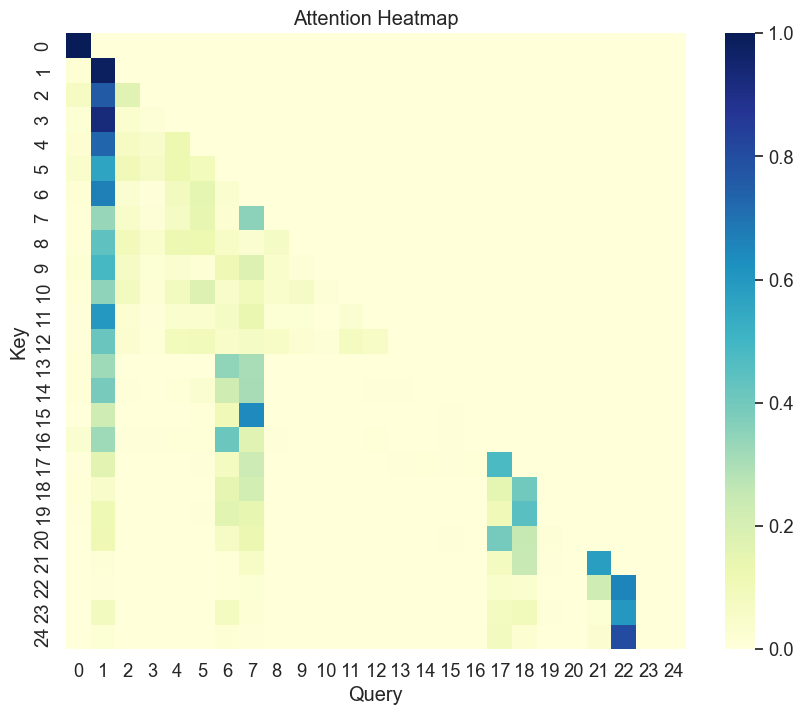

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

input_id=input_id.to('cuda')
segment_id=segment_id.to('cuda')
with torch.no_grad(): 
    TransformerEncoderlayer=model_best.transformer_encoder.layers[0]

    attention_weights=TransformerEncoderlayer.attention_layers.attention_weights
    print(attention_weights.shape)
    attention_weights = attention_weights.squeeze(0)  # 去除批次维度
    attention_weights = attention_weights.reshape(16, 25, 25)  # 调整形状为 (注意力头数, 查询长度, 键长度)

# 在需要可视化注意力权重的地方添加以下代码
def visualize_attention(attention_weights):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(attention_weights, cmap="YlGnBu")
    plt.xlabel("Query")
    plt.ylabel("Key")
    plt.title("Attention Heatmap")
    plt.show()
visualize_attention(attention_weights[1])

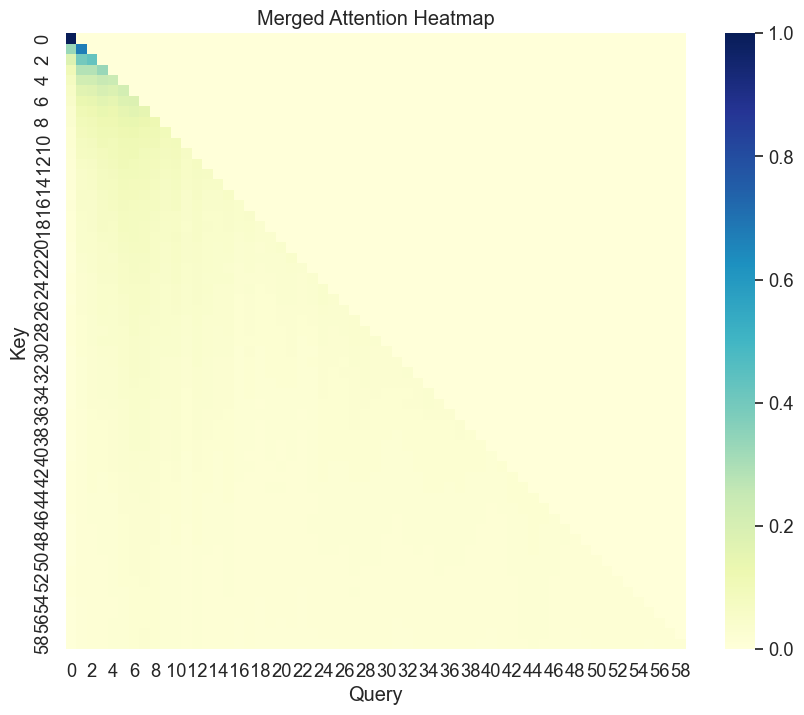

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

input_id=input_id.to('cuda')
segment_id=segment_id.to('cuda')
with torch.no_grad(): 
    embedding_layer=model_best.EmbeddingLayer.forward(input_id,segment_id)
    MultiHeadSelfAttention=model_best.transformer_encoder.layers[0].attention_layers
    
    attention_output=model_best.transformer_encoder.layers[0].attention_layers(embedding_layer,embedding_layer,embedding_layer)
    attention_weights=MultiHeadSelfAttention.attention_weights


def visualize_attention(attention_weights):
     # 计算64个样本的平均注意力权重
    mean_sample_attn_weights = np.mean(attention_weights, axis=0)
    
    # 计算16个自注意力头的平均注意力权重
    mean_head_attn_weights = np.mean(mean_sample_attn_weights, axis=0)
    
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(mean_head_attn_weights, cmap="YlGnBu")
    plt.xlabel("Query")
    plt.ylabel("Key")
    plt.title("Merged Attention Heatmap")
    plt.show()
visualize_attention(attention_weights)

In [ ]:
def visualize_attention(attention_weights):
    # 计算64个样本的平均注意力权重
    mean_sample_attn_weights = np.mean(attention_weights, axis=0)
    
    # 计算16个自注意力头的平均注意力权重
    mean_head_attn_weights = np.mean(mean_sample_attn_weights, axis=0)
    
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(mean_head_attn_weights, cmap="YlGnBu")
    
    # 在每个格子里添加具体数值标签
    for i in range(mean_head_attn_weights.shape[0]):
        for j in range(mean_head_attn_weights.shape[1]):
            ax.text(j + 0.5, i + 0.5, "{:.2f}".format(mean_head_attn_weights[i, j]),
                    ha='center', va='center', color='black', fontsize=10)
    
    plt.xlabel("Query")
    plt.ylabel("Key")
    plt.title("Merged Attention Heatmap")
    plt.show()

visualize_attention(attention_weights)

In [22]:
from graphviz import Digraph
import os

def generate_model_structure(model, filename):
    os.environ["PATH"] += os.pathsep + 'F:\Anaconda\envs\program\Lib\site-packages'
    # 创建Graph对象
    graph = Digraph(format='png')

    # 添加EmbeddingLayer节点和边
    graph.node('EmbeddingLayer', label='EmbeddingLayer')
    graph.edge('EmbeddingLayer', 'transformer_encoder')

    # 添加EmbeddingLayer内部结构节点和边
    graph.node('dropout', label='Dropout')
    graph.node('inputs_embedding', label='Embedding(17964, 256)')
    graph.node('segment_embedding', label='Embedding(2, 256)')

    graph.edge('EmbeddingLayer', 'dropout')
    graph.edge('dropout', 'inputs_embedding')
    graph.edge('dropout', 'segment_embedding')

    # 添加TransformerEncoder节点和边
    graph.node('transformer_encoder', label='TransformerEncoder')
    graph.edge('transformer_encoder', 'classifier')

    # 添加TransformerEncoder内部结构节点和边
    for i in range(len(model.transformer_encoder.layers)):
        layer_name = f'{i}-{i+3}'
        graph.node(layer_name, label='TransformerEncoderLayer')

        graph.edge('transformer_encoder', layer_name)

        graph.node('attention_layers', label='MultiHeadSelfAttention')
        graph.node('ffn_layers', label='Feedforward')
        graph.node('norm_layers', label='AddAndNorm')
        graph.node('dropout_layer', label='Dropout')

        graph.edge(layer_name, 'attention_layers')
        graph.edge(layer_name, 'ffn_layers')
        graph.edge(layer_name, 'norm_layers')
        graph.edge(layer_name, 'dropout_layer')

        # 添加MultiHeadSelfAttention内部结构节点和边
        graph.node('q_linear', label='Linear')
        graph.node('k_linear', label='Linear')
        graph.node('v_linear', label='Linear')
        graph.node('out_linear', label='Linear')

        graph.edge('attention_layers', 'q_linear')
        graph.edge('attention_layers', 'k_linear')
        graph.edge('attention_layers', 'v_linear')
        graph.edge('attention_layers', 'out_linear')

        # 添加Feedforward内部结构节点和边
        graph.node('fc1', label='Linear')
        graph.node('relu', label='ReLU')
        graph.node('fc2', label='Linear')
        graph.node('dropout', label='Dropout')

        graph.edge('ffn_layers', 'fc1')
        graph.edge('ffn_layers', 'relu')
        graph.edge('ffn_layers', 'fc2')
        graph.edge('ffn_layers', 'dropout')

        # 添加AddAndNorm内部结构节点和边
        graph.node('layer_norm', label='LayerNorm')

        graph.edge('norm_layers', 'layer_norm')

    # 添加Classifier节点和边
    graph.node('classifier', label='Linear')

    # 保存并渲染图像
    graph.render(filename, view=True)

In [23]:
generate_model_structure(model, 'model_structure')

修改为post-norm

In [ ]:
class TransformerEncoderlayer_1(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim,dropout=0.1):
        super(TransformerEncoderlayer_1, self).__init__()
        self.attention_layers = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn_layers = Feedforward(d_model, hidden_dim, dropout)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x):
        attention_output = self.attention_layers(x,x,x)
        attention_output = self.norm1(attention_output + x)

        ffn_output = self.ffn_layers(attention_output)
        output = self.norm2(ffn_output + attention_output)
        
        output = self.dropout(output)
        return output
    
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, hidden_dim, num_layers, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList(
            [TransformerEncoderlayer_1(d_model, n_heads, hidden_dim, dropout) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [ ]:
class SemanticMatchingModel_1(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim, num_layers,vocab):
        super(SemanticMatchingModel_1, self).__init__()
        self.vocab = vocab
        self.EmbeddingLayer=EmbeddingLayer(self.vocab,embedding_dim=256)
        self.transformer_encoder = TransformerEncoder(d_model, num_heads, hidden_dim, num_layers)
        self.classifier = nn.Linear(d_model, 2)

    def forward(self,inputs,segment):
        embedding_layer=self.EmbeddingLayer.forward(inputs,segment)

        encoded = self.transformer_encoder(embedding_layer)
        encoded, _ = encoded.max(dim=1)
        logits = self.classifier(encoded)
        
        return logits

In [ ]:
SemanticMatchingModel_post=SemanticMatchingModel_1(d_model=256, num_heads=16, hidden_dim=512, num_layers=2,vocab=data.vocab)

In [ ]:
SemanticMatchingModel_post.to('cuda')

SemanticMatchingModel_1(
  (EmbeddingLayer): EmbeddingLayer(
    (dropout): Dropout(p=0.1, inplace=False)
    (inputs_embedding): Embedding(17964, 256, padding_idx=0)
    (segment_embedding): Embedding(2, 256, padding_idx=0)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderlayer_1(
        (attention_layers): MultiHeadSelfAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (out_linear): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ffn_layers): Feedforward(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (relu): ReLU()
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from datetime import datetime

from tensorboardX import SummaryWriter

# 获取当前时间
now = datetime.now().strftime("%Y%m%d-%H%M%S")

# 创建SummaryWriter对象，指定保存日志的路径，包含当前时间

log_dir = f"./logs/{now}"
writer = SummaryWriter(log_dir=log_dir)
# 使用DataLoader加载数据
batch_size = 64
train_dataloader = DataLoader(data.dataset_train_oversampled, batch_size=batch_size,shuffle=True,collate_fn=data.collate_fn)
dev_dataloader = DataLoader(data.dataset_dev, batch_size=batch_size, shuffle=True,collate_fn=data.collate_fn)


In [34]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(SemanticMatchingModel_post.parameters(), lr=0.0001)

# 训练模型
num_epochs = 30

In [35]:
import copy
best_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_count = 0
    total_count = 0

    with tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training", unit="batch") as train_bar:
        for item in train_bar:
            input_id, segment_id, label = item
            input_id = input_id.to('cuda')
            segment_id = segment_id.to('cuda')
            label = label.to('cuda')
            optimizer.zero_grad()
            output = SemanticMatchingModel_post(input_id, segment_id)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct_count += (predicted == label).sum().item()
            total_count += label.size(0)

            train_bar.set_postfix(loss=loss.item(), accuracy=correct_count / total_count)

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_count / total_count

        # 记录loss和accuracy
    writer.add_scalar("Train/Loss", avg_loss, epoch)
    writer.add_scalar("Train/Accuracy", accuracy, epoch)

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    model.eval()
    total_loss = 0.0
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        with tqdm(dev_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation", unit="batch") as dev_bar:
            for item in dev_bar:
                input_id, segment_id, label = item
                input_id = input_id.to('cuda')
                segment_id = segment_id.to('cuda')
                label = label.to('cuda')
                output = SemanticMatchingModel_post(input_id, segment_id)
                loss = criterion(output, label)
                total_loss += loss.item()

                _, predicted = torch.max(output, 1)
                correct_count += (predicted == label).sum().item()
                total_count += label.size(0)

                dev_bar.set_postfix(loss=loss.item(), accuracy=correct_count / total_count)

    avg_loss = total_loss / len(dev_dataloader)
    accuracy = correct_count / total_count
    if accuracy > best_accuracy:
        if epoch < 5:#前5轮不计入best_model的数据，loss和正确率正常记录
            continue
        else:
            best_accuracy = accuracy
            model_best = copy.deepcopy(SemanticMatchingModel_post)
            model_best = model_best.to('cpu')
            model.to('cuda')
    # 记录loss和accuracy
    writer.add_scalar("val/Loss", avg_loss, epoch)
    writer.add_scalar("val/Accuracy", accuracy, epoch)
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
# 关闭SummaryWriter
# 打印最高正确率
print(f"Best Validation Accuracy: {best_accuracy:.4f}")
torch.save(model_best,'./model/best_model_layer4_post.pth')
writer.close()

Epoch 1/30 - Training: 100%|██████████| 372/372 [00:25<00:00, 14.55batch/s, accuracy=0.528, loss=0.668]


Epoch 1/30 - Training Loss: 0.6981, Accuracy: 0.5276


Epoch 2/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.17batch/s, accuracy=0.572, loss=0.623]


Epoch 2/30 - Training Loss: 0.6777, Accuracy: 0.5718


Epoch 3/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 14.95batch/s, accuracy=0.6, loss=0.491]  


Epoch 3/30 - Training Loss: 0.6614, Accuracy: 0.6002


Epoch 4/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 14.99batch/s, accuracy=0.62, loss=0.728] 


Epoch 4/30 - Training Loss: 0.6489, Accuracy: 0.6195


Epoch 5/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.01batch/s, accuracy=0.651, loss=0.625]


Epoch 5/30 - Training Loss: 0.6274, Accuracy: 0.6507


Epoch 6/30 - Training: 100%|██████████| 372/372 [00:23<00:00, 15.63batch/s, accuracy=0.681, loss=0.547]


Epoch 6/30 - Training Loss: 0.6036, Accuracy: 0.6809


Epoch 6/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 21.85batch/s, accuracy=0.514, loss=0.668]


Epoch 6/30 - Validation Loss: 0.7446, Accuracy: 0.5139


Epoch 7/30 - Training: 100%|██████████| 372/372 [00:23<00:00, 15.52batch/s, accuracy=0.701, loss=0.53] 


Epoch 7/30 - Training Loss: 0.5823, Accuracy: 0.7011


Epoch 7/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 21.66batch/s, accuracy=0.576, loss=0.768]


Epoch 7/30 - Validation Loss: 0.6877, Accuracy: 0.5755


Epoch 8/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.46batch/s, accuracy=0.729, loss=0.581]


Epoch 8/30 - Training Loss: 0.5565, Accuracy: 0.7293


Epoch 8/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.06batch/s, accuracy=0.484, loss=0.711]


Epoch 8/30 - Validation Loss: 0.7963, Accuracy: 0.4842


Epoch 9/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.02batch/s, accuracy=0.755, loss=0.457]


Epoch 9/30 - Training Loss: 0.5277, Accuracy: 0.7550


Epoch 9/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 21.37batch/s, accuracy=0.618, loss=0.554]


Epoch 9/30 - Validation Loss: 0.6609, Accuracy: 0.6184


Epoch 10/30 - Training: 100%|██████████| 372/372 [00:25<00:00, 14.85batch/s, accuracy=0.78, loss=0.579] 


Epoch 10/30 - Training Loss: 0.4991, Accuracy: 0.7798


Epoch 10/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.50batch/s, accuracy=0.618, loss=0.571]


Epoch 10/30 - Validation Loss: 0.6609, Accuracy: 0.6179


Epoch 11/30 - Training: 100%|██████████| 372/372 [00:25<00:00, 14.70batch/s, accuracy=0.798, loss=0.616]


Epoch 11/30 - Training Loss: 0.4686, Accuracy: 0.7981


Epoch 11/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 18.23batch/s, accuracy=0.565, loss=0.7]  


Epoch 11/30 - Validation Loss: 0.7310, Accuracy: 0.5649


Epoch 12/30 - Training: 100%|██████████| 372/372 [00:27<00:00, 13.70batch/s, accuracy=0.824, loss=0.483]


Epoch 12/30 - Training Loss: 0.4337, Accuracy: 0.8241


Epoch 12/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.06batch/s, accuracy=0.538, loss=0.896]


Epoch 12/30 - Validation Loss: 0.7830, Accuracy: 0.5382


Epoch 13/30 - Training: 100%|██████████| 372/372 [00:25<00:00, 14.33batch/s, accuracy=0.841, loss=0.409]


Epoch 13/30 - Training Loss: 0.4039, Accuracy: 0.8411


Epoch 13/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.43batch/s, accuracy=0.579, loss=0.779]


Epoch 13/30 - Validation Loss: 0.7362, Accuracy: 0.5790


Epoch 14/30 - Training: 100%|██████████| 372/372 [00:25<00:00, 14.39batch/s, accuracy=0.857, loss=0.202]


Epoch 14/30 - Training Loss: 0.3719, Accuracy: 0.8566


Epoch 14/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 19.83batch/s, accuracy=0.557, loss=0.737]


Epoch 14/30 - Validation Loss: 0.7841, Accuracy: 0.5570


Epoch 15/30 - Training: 100%|██████████| 372/372 [00:26<00:00, 14.06batch/s, accuracy=0.877, loss=0.427]


Epoch 15/30 - Training Loss: 0.3360, Accuracy: 0.8768


Epoch 15/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.43batch/s, accuracy=0.559, loss=1.01] 


Epoch 15/30 - Validation Loss: 0.8183, Accuracy: 0.5593


Epoch 16/30 - Training: 100%|██████████| 372/372 [00:25<00:00, 14.86batch/s, accuracy=0.893, loss=0.439]


Epoch 16/30 - Training Loss: 0.3046, Accuracy: 0.8926


Epoch 16/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.89batch/s, accuracy=0.571, loss=0.904]


Epoch 16/30 - Validation Loss: 0.7955, Accuracy: 0.5709


Epoch 17/30 - Training: 100%|██████████| 372/372 [00:25<00:00, 14.62batch/s, accuracy=0.908, loss=0.342]


Epoch 17/30 - Training Loss: 0.2735, Accuracy: 0.9084


Epoch 17/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.17batch/s, accuracy=0.572, loss=1.01] 


Epoch 17/30 - Validation Loss: 0.8426, Accuracy: 0.5723


Epoch 18/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 14.97batch/s, accuracy=0.922, loss=0.261]


Epoch 18/30 - Training Loss: 0.2455, Accuracy: 0.9218


Epoch 18/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 21.03batch/s, accuracy=0.607, loss=0.761]


Epoch 18/30 - Validation Loss: 0.8023, Accuracy: 0.6073


Epoch 19/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.23batch/s, accuracy=0.933, loss=0.166]


Epoch 19/30 - Training Loss: 0.2174, Accuracy: 0.9327


Epoch 19/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.86batch/s, accuracy=0.603, loss=0.652]


Epoch 19/30 - Validation Loss: 0.8374, Accuracy: 0.6026


Epoch 20/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.27batch/s, accuracy=0.939, loss=0.159]


Epoch 20/30 - Training Loss: 0.1938, Accuracy: 0.9393


Epoch 20/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.57batch/s, accuracy=0.614, loss=0.784]


Epoch 20/30 - Validation Loss: 0.8460, Accuracy: 0.6138


Epoch 21/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.07batch/s, accuracy=0.951, loss=0.0918]


Epoch 21/30 - Training Loss: 0.1661, Accuracy: 0.9515


Epoch 21/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 19.66batch/s, accuracy=0.586, loss=0.953]


Epoch 21/30 - Validation Loss: 0.9269, Accuracy: 0.5860


Epoch 22/30 - Training: 100%|██████████| 372/372 [00:23<00:00, 15.55batch/s, accuracy=0.96, loss=0.146]  


Epoch 22/30 - Training Loss: 0.1446, Accuracy: 0.9601


Epoch 22/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 19.48batch/s, accuracy=0.581, loss=0.696]


Epoch 22/30 - Validation Loss: 0.9946, Accuracy: 0.5809


Epoch 23/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.04batch/s, accuracy=0.967, loss=0.337] 


Epoch 23/30 - Training Loss: 0.1247, Accuracy: 0.9670


Epoch 23/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.65batch/s, accuracy=0.586, loss=0.664]


Epoch 23/30 - Validation Loss: 1.0140, Accuracy: 0.5862


Epoch 24/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.15batch/s, accuracy=0.97, loss=0.0909] 


Epoch 24/30 - Training Loss: 0.1098, Accuracy: 0.9702


Epoch 24/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 21.19batch/s, accuracy=0.591, loss=0.685]


Epoch 24/30 - Validation Loss: 1.0551, Accuracy: 0.5913


Epoch 25/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.26batch/s, accuracy=0.976, loss=0.095] 


Epoch 25/30 - Training Loss: 0.0930, Accuracy: 0.9763


Epoch 25/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 21.17batch/s, accuracy=0.602, loss=1.26] 


Epoch 25/30 - Validation Loss: 1.0741, Accuracy: 0.6022


Epoch 26/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.17batch/s, accuracy=0.981, loss=0.0665]


Epoch 26/30 - Training Loss: 0.0818, Accuracy: 0.9811


Epoch 26/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 21.15batch/s, accuracy=0.636, loss=1.51] 


Epoch 26/30 - Validation Loss: 1.0860, Accuracy: 0.6355


Epoch 27/30 - Training: 100%|██████████| 372/372 [00:24<00:00, 15.16batch/s, accuracy=0.984, loss=0.0395]


Epoch 27/30 - Training Loss: 0.0698, Accuracy: 0.9838


Epoch 27/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.37batch/s, accuracy=0.549, loss=1.29] 


Epoch 27/30 - Validation Loss: 1.3685, Accuracy: 0.5491


Epoch 28/30 - Training: 100%|██████████| 372/372 [00:25<00:00, 14.47batch/s, accuracy=0.987, loss=0.023] 


Epoch 28/30 - Training Loss: 0.0609, Accuracy: 0.9868


Epoch 28/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 21.45batch/s, accuracy=0.639, loss=1.46] 


Epoch 28/30 - Validation Loss: 1.1691, Accuracy: 0.6395


Epoch 29/30 - Training: 100%|██████████| 372/372 [00:25<00:00, 14.79batch/s, accuracy=0.99, loss=0.0236] 


Epoch 29/30 - Training Loss: 0.0505, Accuracy: 0.9896


Epoch 29/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 19.79batch/s, accuracy=0.598, loss=0.87] 


Epoch 29/30 - Validation Loss: 1.3195, Accuracy: 0.5985


Epoch 30/30 - Training: 100%|██████████| 372/372 [00:25<00:00, 14.75batch/s, accuracy=0.99, loss=0.0668] 


Epoch 30/30 - Training Loss: 0.0454, Accuracy: 0.9900


Epoch 30/30 - Validation: 100%|██████████| 68/68 [00:03<00:00, 20.22batch/s, accuracy=0.604, loss=1.09] 


Epoch 30/30 - Validation Loss: 1.2681, Accuracy: 0.6045
Best Validation Accuracy: 0.6395
